### [Author: John (Jack) Messerly](https://www.linkedin.com/in/jack-messerly-567b9b96/)
### [Main Project Page](https://messy-bytes.github.io/Advanced-ML-Color-Fixes/)
<br>

Finally, we arrive at the machine-learning part of this post. There are two "regressors" involved here: a KL Divergence regressor that removes colored lighting from a latent representation of our original image, and a simple MSE regressor that recolors the original image using the output of the color balancer. 

<br>

## The Major Network: Color Balancing with KL Divergence

As I mentioned earlier, we will be using Autoencoders from HuggingFace and training our "image fixer" network in a latent space. This space enables us to remove color distortions more efficiently than working with images directly. Training in this compressed space offers the same benefits it gives to AI art generation but without the downsides. Because we plan on mapping the colorspace we learn to our original image, we will not lose any high-frequency details, unlike in img2img art generation, in which the output can have distortions like weird faces and an overall blur. The benefits we take from using a VAE include:

1. **Runtime Efficiency**: By using compressed latent vectors, you can significantly speed up your training process due to the smaller size of the data. This results in the ability to train a high-performing network that can generalize effectively in under 20 minutes*, which is not achievable when using sized (224x224) images. In my implementation without a VAE, each epoch took 220 seconds, while with VAE it only took 30 seconds. However, it's not a direct comparison since I had to reduce the number of parameters in the "regular CNN" implementation significantly to make it run without being killed by the OS. It's not new to use VAEs for cutting down on the computational cost of image processing algorithms. This is the entire reason VAEs were included in Stable Diffusion. So, this is not surprising.


2. **Regularization Benefits**: Overfitting is not a major concern when training in the latent space of a VAE, because the encoded space is already forced to be regular during the VAE's training routine (such that encoded vectors are close to N(0,1)). Therefore, I did not need dropout, weight decay, or any other regularization strategies when training this network. However, the non-VAE version I trained did require them.

<br>

*Note: although you can get away with 3,000 distortion pairs and 20 minutes of training and be able to restore many kinds of images, my final results used about 7x as many images to include things like "enhanced faces", and training took a little over two hours.*

<br>
<br>

## The Minor Network: Rebuilding a High Resolution Image with MSE


After the color-balanced encoding is decoded, it results in a small image of 224 x 224 pixels with distorted details. We need to restore this image to its original high-resolution state. Fortunately, this is a straightforward process. We align the distorted image with the "restored" 224 x 224 image and train a "color classifier" using polynomial regression or a single-layer MLP. Although a linear regressor works, a nonlinear model is preferred for this task.

<br>


## A Note on Recursive Application

Because we "resample" the image structure at the end, we can assume that shapes and lines are not distorted by this denoising pipeline. Thus, we can apply this method to our image over and over again, and we should not get image structure distortions. I wouldn't consider this a "theoretically groundbreaking" technique, but it is important. I recommend all color enhancement algorithms do this because it's a practical way to enhance a large image while working with smaller ones. I've noticed, however, that this "recursive application" works particularly well with my denoising algorithm, when compared to a version of it that does not use a VAE. I attempt to explain in this post why I think that is later on.

<br>




# Variational Autoencoders and the Latent Space

I did not provide a background section on Variational Autoencoders as explaining it from scratch would be difficult. However, there are many great resources available that cover this topic and its connections to other commonly taught subjects in ECE graduate school, such as PCA and Boltzmann machines. One excellent article on this topic was written by Joseph Rocca and can be found on TowardsDataScience. It is worth mentioning that he was a full-time employee at the site when he wrote it.

[Joseph Rocca's VAE Guide](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

### Stability AI's VAE

To begin exploring AI art and Stable Diffusion, visit HuggingFace's diffuser library page. Personally, I didn't appreciate machine learning until I discovered HuggingFace. Their collection of pre-trained models is comprehensive, welcoming, and user-friendly. Additionally, their source code is easy to comprehend, without the confusing abstractions found in other scientific libraries. A statement of their philosophy can be found [here](https://huggingface.co/docs/transformers/philosophy).

## Denoising Overview (with MS Paint)

Let's say I have an image that has some intricate distortions, which are marked by pink squiggles in the figure.

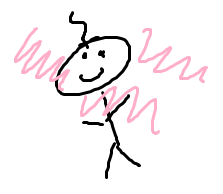

To use our Variational Autoencoder [sd-vae-ft-mse-original](https://huggingface.co/stabilityai/sd-vae-ft-mse-original), the images must be sized 224x224x3. Therefore, we need to resize the original image, which can have any arbitrary dimensions. It is best to center crop the image. You can still perform color balancing on the original image as we are only learning a colormap, which we will later apply back to our original image (in its original dimension).

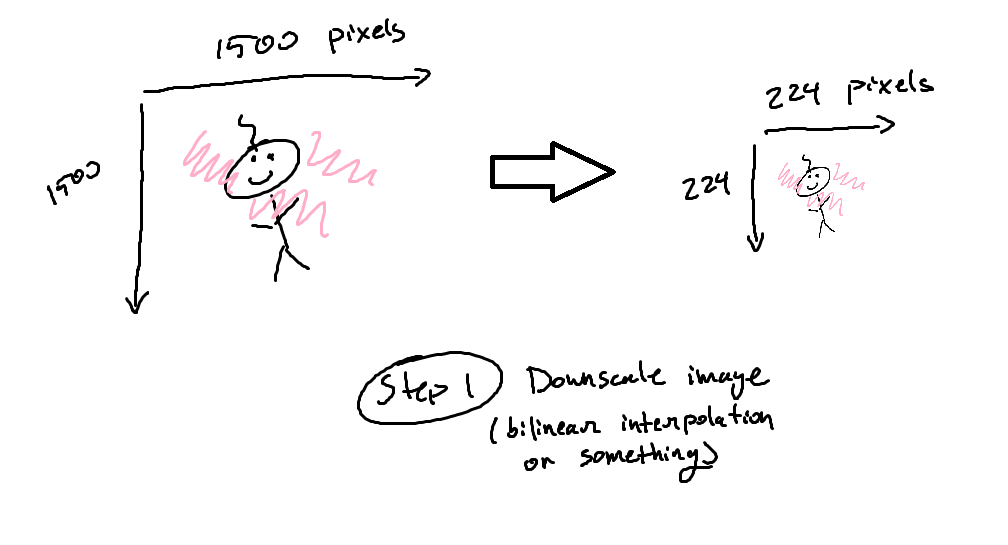

Next we encode our image into Stability AI's "latent space"


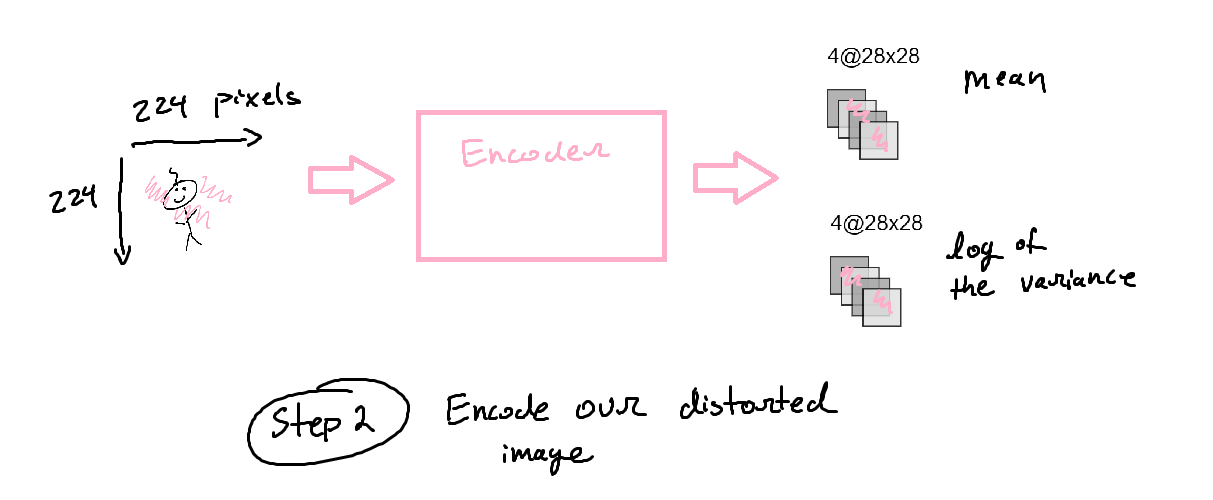

We will be using KL Divergence to train our network on the mean and variance vector. Our goal during training is to teach the network to convert distorted encoded distributions to restored encoded distributions. This approach has numerous benefits, as the Variational Autoencoder we are using is already designed to map inputs to distributions similar to N(0,1). This ensures that the data in the encoded space remains highly regular. By training our network on this regulated encoded space, we can minimize the need for additional regularization in our own network.

<br>

*Note: github pages doesn't support LaTeX easily, forgive me for not using \mathcal{N} to denote a gaussian distribution*

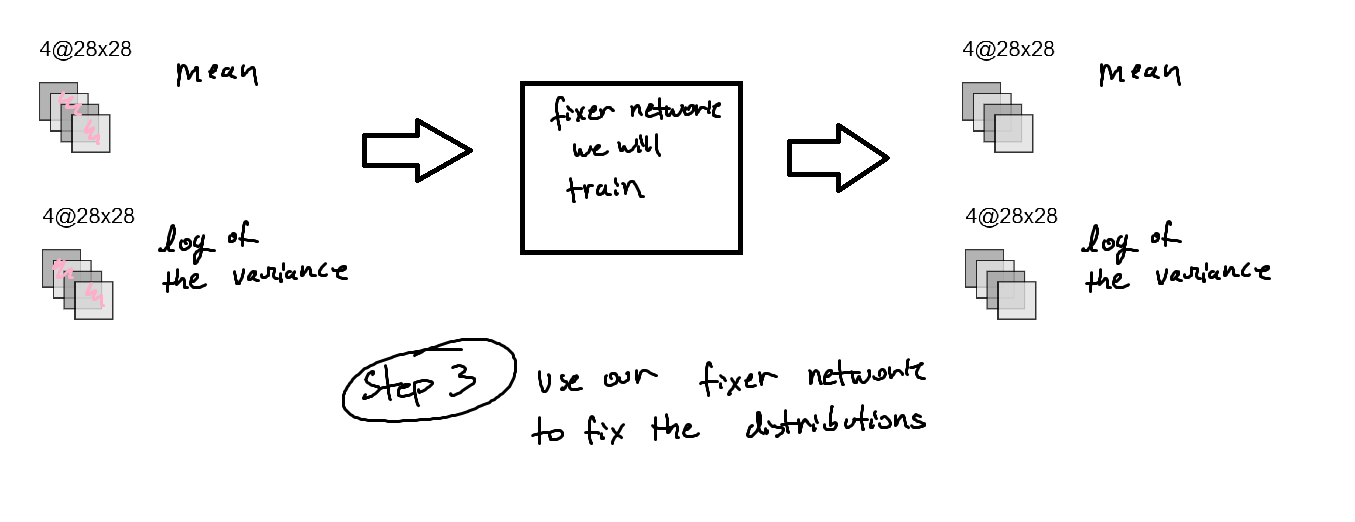

We can decode the "fixed encoding" to get a compressed version of our original image, which should be a cleaner version of the original. Please note that the output may have some phase distortions such as bent lines or distorted faces. However, since we are only learning a colormap, these distortions will not really affect our final output.

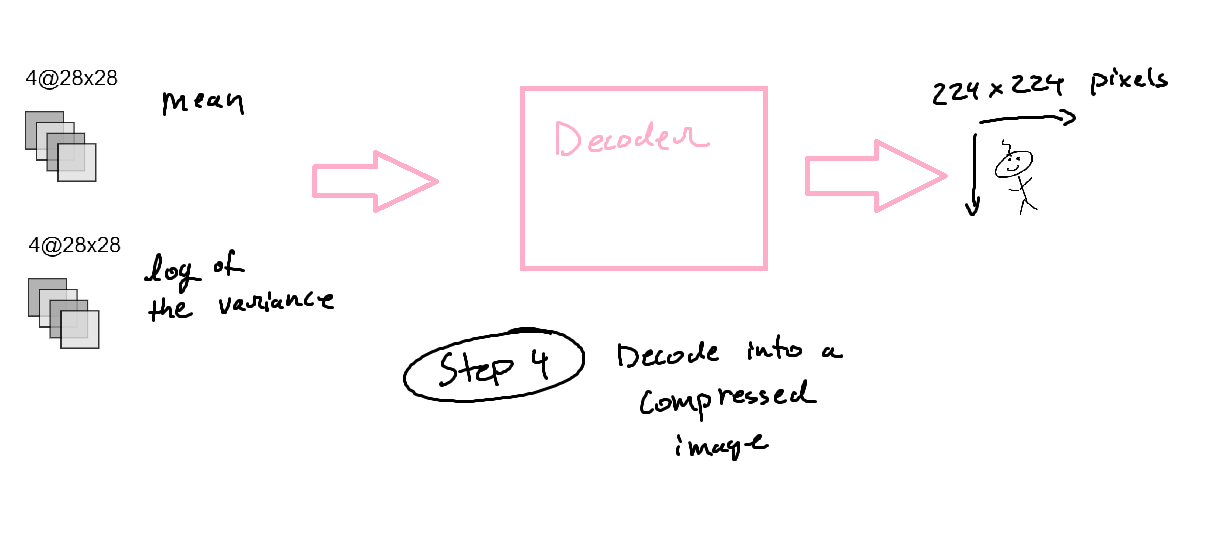

We now learn a color map between our compressed images using linear regression, an MLP, or polynomial interpolation. This will be used to resample the pixels in our original (high-resolution) image. I used MSE as the loss function and for image pixel regression this is the norm.

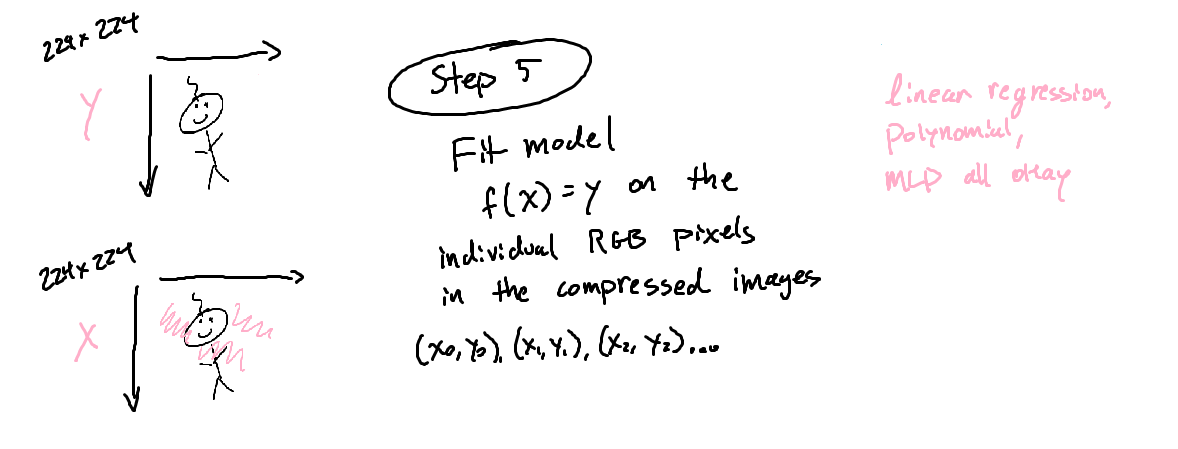

Use this color map on your original image and you're done!

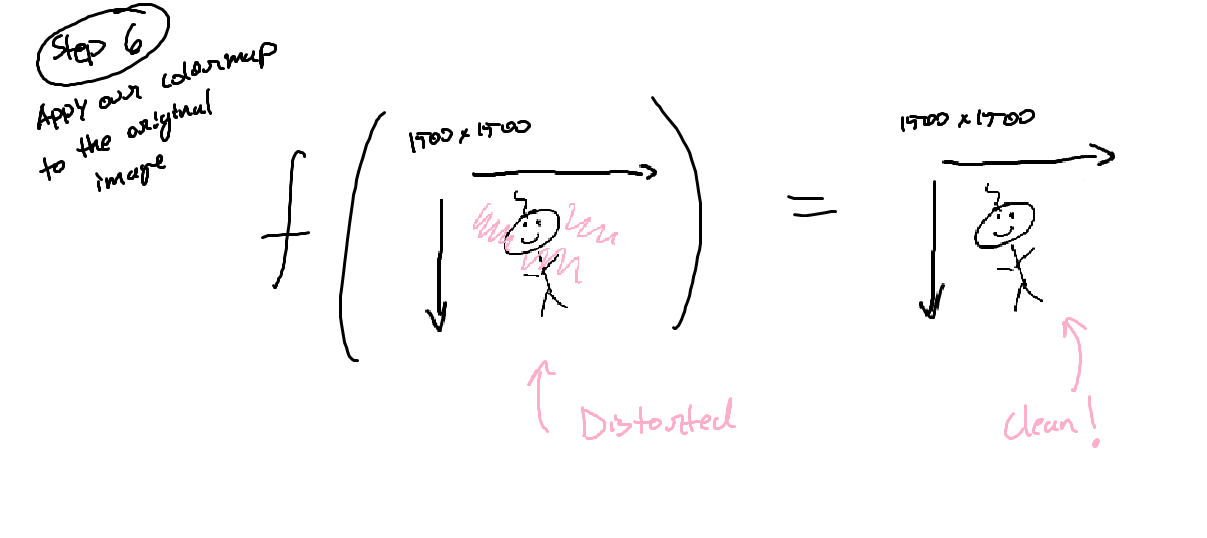

### (Potential) Recursive Application Advantages

By sampling the structure of the image directly at the end, you can repeatedly use this denoising pipeline without any significant loss in quality. This technique can be iteratively applied to obtain even cleaner results. While this can be done with any retouching pipeline, it seems to work unreasonably well in this denoising pipeline. Observe, on the top is some recursive applications using a denoising system with a VAE, and on the bottom is the same thing, but using a system that denoises images with a CNN directly: 

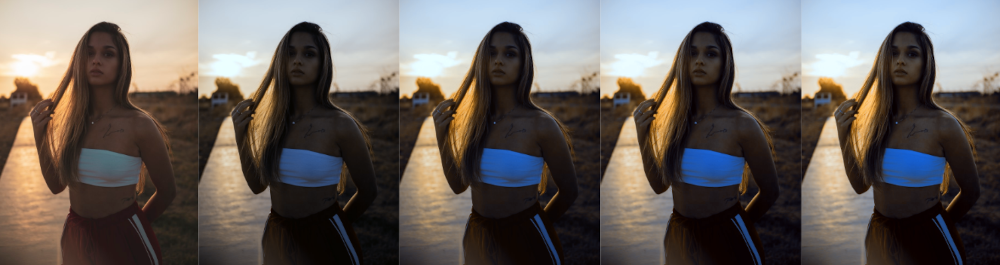

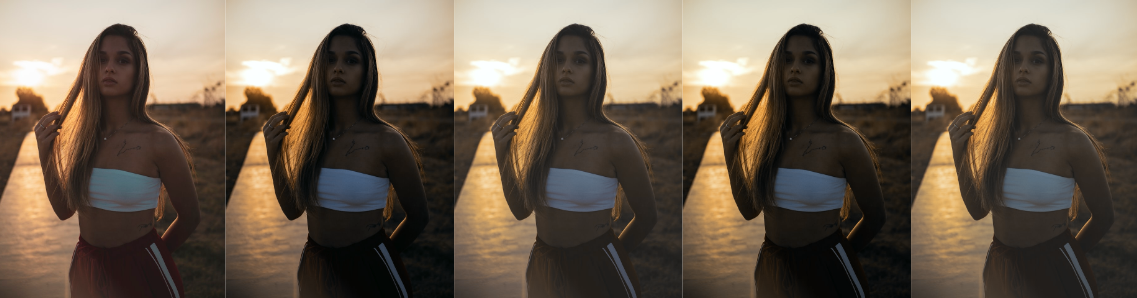

Interestingly, the non-VAE implementation oscillates. It just bounces back and forth between two images if it can't solve it right the first time. I offer three possible explanations:

1. The VAE implementation has a "sampling" step during the decoding process.This makes the output slightly random. During repeated applications, I think this small amount of randomness prevents our pipeline from easily getting stuck in a minima.

2. The VAE operates in a very regular data space, where distorted images are very "close" to each other. This might help close gaps during a repeated application. The non-VAE implementation, on the otherhand, has to make comparatively large leaps, and it's easy to see how it would get stuck or oscillate.

3. The VAE network is just trained better. I had to use fewer parameters in the non-VAE implementation (in order to get it to run on my OS), and I also had to use regularization like dropout. I could have just trained it worse because its a tougher ML problem to regress images directly.




### Code Implementation

In the last stretches of this post, we will:

1. Learn how to use one of Stable Diffusion's simplest Variational Autoencoders
2. Build + train a fully convolutional network to minimize KL Divergence between an encoded "distorted" image, and an encoded "true" image
3. Reconstruct the original image at full (arbitrary) resolution using an MSE color regressor

You can use this .ipynb to do this project yourself, using the data generation scripts I've also left in the github for this project's page.

### Basic Installs

In [ ]:
!pip install diffusers==0.11.1 transformers ftfy accelerate
!pip install colour-science

### Basic Imports

In [ ]:
import numpy as np
import torch
from PIL import Image
from diffusers.models import AutoencoderKL
import requests
from torchvision.transforms import CenterCrop, Resize
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt

### Loading the Varational Autoencoder

The VAE we're using today is a variation of UNET with attention layers. Its  [cover page is here](https://huggingface.co/stabilityai/sd-vae-ft-mse-original). This network was trained on [LAOIN's](https://laion.ai/blog/laion-aesthetics/) datasets. I recommend following along with [the source code here](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/vae.py).

In [ ]:
# takes 224x224x3 images, and encodes them into a 28x28x4 mean vector, as well
# as a 28x28x4 variance vector (gaussian distribution)
IMAGE_DIM = 224
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")

### Preparing our image

When resizing your images to a fixed dimension, make sure to center crop them. It's not necessary to normalize your image, and in fact, I suggest that you don't do it before feeding it into the autoencoder.

In [ ]:
url = 'https://images.pexels.com/photos/6205778/pexels-photo-6205778.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'

image = Image.open(requests.get(url, stream=True).raw)

dim = min(image.size[0],image.size[1])
transforms = torch.nn.Sequential(
    CenterCrop((dim,dim)),
    Resize((IMAGE_DIM,IMAGE_DIM))
)

image = transforms(image)
image

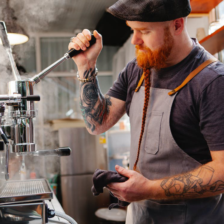

### The encoded vector is no longer an image

It's worth noting that the encoded distribution is not an image in the traditional sense. Instead of pixels, the distribution is made up of floating point numbers that can range from -5 to 18 or from 25 to 66. They haven't been normalized to fit within the range of 0 to 1 using the sigmoid function, so you can't apply image processing or color theory to them directly. However, if you examine the mean vectors closely, you may be able to make out the shape of the barista. With practice, you can learn to identify what the network is learning using its attention layers and feature maps, much like looking into a crystal ball.



In [ ]:
# need defined batch size. shape should be [1,3,224,224]
image_tensor = to_tensor(image).unsqueeze(0)

# "latent_dist" is a diffusers.models.vae.DiagonalGaussianDistribution object
with torch.no_grad():
  latent_dist = vae.encode(image_tensor).latent_dist

# the logvar is more useful for us (used in loss function)
gauss = torch.cat((latent_dist.mean,latent_dist.logvar),dim=1)

# nump-ify it for plotting, etc.
gauss = gauss.squeeze(0).numpy()

fig,axes = plt.subplots(2,4)
for i in range(4):
  axes[0,i].imshow(gauss[i,:,:])
  axes[1,i].imshow(gauss[i+4,:,:])
  axes[0,i].set_title('mean ch' + str(i))
  axes[1,i].set_title('logvar ch' + str(i))




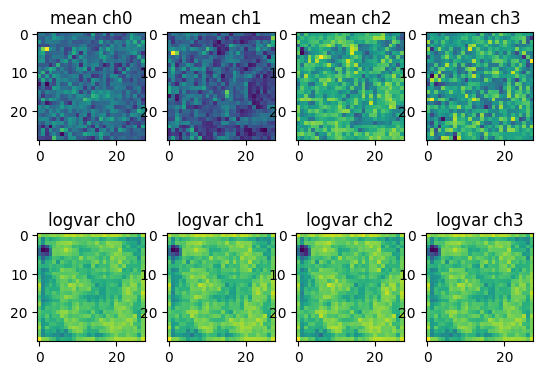

### But it can be decoded... reasonably well

Although his face is not in good condition, it's not relevant for our purpose of learning color maps.

In [ ]:
# sample out a [1,4,28,28] vector from the distribution
sample = latent_dist.sample()

# image output is wrapped in a "sample" parameter
# for some reason
with torch.no_grad():
  decoded = vae.decode(sample).sample

# output is between 0 and 1 in theory, but you have to 
# clip it a little bit
decoded = decoded.squeeze(0).permute(1,2,0).numpy()
decoded = np.clip(decoded,0,1)
decoded = (decoded * 255).astype(np.uint8)
decoded = Image.fromarray(decoded)
decoded

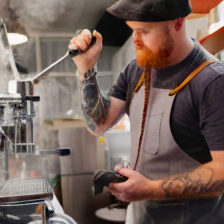

## Setting up the network architecture / training loop

In the [second part of this blog post](https://messy-bytes.github.io/Advanced-ML-Color-Fixes/2023/05/03/Dataset-Curation.html), we thoroughly discussed the process of creating a dataset of "true" and "distorted" image pairs to effectively remove complex colored lighting effects. Now, let's set up a basic architecture/training loop in Pytorch. Essentially, any fully convolutional neural network with adequate parameters can be used for this task. Here are a few important points to keep in mind:

1. Do not whiten your image before training by dividing out the variance. This will mess up your color channels, and you won't learn anything useful
2. The input encoded images are 28x28x28x8, which isn't very large, so I recommend an input convolutional kernel size of 3. Increasing it beyond that makes the network perform worse. 
3. Stick to Kullback Liebler divergence for your loss function (between your encoded representations). You don't need a reconstruction loss (MSE term)
4. You do need some kind of batch normalization
5. The outptut isn't an image, so no need to add a sigmoid to the end: you're directly regressing a vector of size 28x28x28x8.
6. You do need to learn the variance in addition to the mean, otherwise your decoder won't be able to decode the "phase" of the image (general lines and shapes) very well

Some of the code for this was taken from the [examples section of the pytorch github page ](https://github.com/pytorch/examples/blob/main/fast_neural_style/neural_style/transformer_net.py).

In [ ]:
from torch import nn

class ColorFixer(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

Here we have our loss function. The "pred" variable represents a predicted mean and logvar generated by feeding the encoded representation of a distorted image into your ColorFixer network. It is a 28x28x28x8 matrix. The "label" variable corresponds to the encoded representation of a "non-distorted" image. For those who are unfamiliar, the KL divergence is an information metric that measures how similar our "predicted" latent distribution is to our "target" latent distribution. The tutorial on VAEs I posted at the top of this page is a great reference for learning more about KL Divergence in VAEs, and why it's important.





In [ ]:
# for taking the KL divergence between a predicted 
# gaussian vector, and the encoded "true" gaussian
def KL_loss(pred,label):
  mean_1 = pred[:,:4,:,:]
  var_1 = torch.clip(torch.exp(pred[:,4:,:,:]),min=1e-5)
  mean_2 = label[:,:4,:,:]
  var_2 = torch.clip(torch.exp(label[:,4:,:,:]),min=1e-5)
  kl_loss = lambda mean_1, mean_2, var_1, var_2:(
            torch.log((var_2 / (var_1)) ** 0.5)
              + (var_1 + (mean_1 - mean_2) ** 2) / (2 * var_2)
              - 0.5
           )
  # reduce with the mean or else get really big silly numbers
  loss = kl_loss(mean_1,mean_2,var_1,var_2)
  return loss.mean()

To use the Dataset, you will need a .csv file containing a "data" column and a "label" column that correspond to the file paths of encoded images. The "data" column should contain the distorted set, while the "label" column should contain the corresponding truth set. You can save the encoded representations using the torch.save() function or any other method you prefer. It is not necessary to have the original images for training.


In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class EncodedColorBalanceDataset(Dataset):
  def __init__(self,csv_file, transform=None):
    self.dataframe = pd.read_csv(csv_file)

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    color_file = self.dataframe.iloc[idx]['data']
    truth_file = self.dataframe.iloc[idx]['label']

    color = torch.load(color_file).squeeze(0)
    truth = torch.load(truth_file).squeeze(0)

    return {'distorted':color, 'true':truth}



Train it like any other network



In [ ]:
# batch size of 12 on an nvidia rtx 3070 is ok (12 GB RAM)
device = 'cuda'
batch_size = 12
num_epochs = 50
dataset_csv_file = 'annotations.csv'

fixer = ColorFixer()
fixer.to(device)
optimizer = torch.optim.Adam(fixer.parameters())

dataset = EncodedColorBalanceDataset(dataset_csv_file)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

for epoch in range(num_epochs):
  train_losses = []
  for batch in dataloader:
    optimizer.zero_grad()
    x = batch['distorted'].to(device)
    pred = fixer(x)
    label = batch['true'].to(device)
    loss = KL_loss(pred,label)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.detach().cpu().numpy())
  print(epoch,'loss',np.mean(train_losses))

torch.save(fixer.state_dict(),'my_color_fixer.pth')

As explained in the MS Paint section of this post, the network produces a mean and variance vector that needs to be decoded using the VAE's decoder. After that, a regression technique is used to learn the color map, which can then be applied to the original high-resolution image.


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



# build and apply a colormap with an MLP 
# 
# distorted and fixed are 224x224x3 8 bit arrays [0,255]
# original image is any dim, but 8 bit [0,225]
def colormap_MLP(distorted_224,fixed_224,original_image):

  distorted_pixels = (distorted_224.astype(float) / 255).reshape((224*224,3))
  fixed_pixels = (fixed_224.astype(float) / 255).reshape((224*224,3))

  clf = MLPRegressor(activation='relu',
                    hidden_layer_sizes=(32),
                    alpha=0.001,
                    random_state=20)
  clf.fit(distorted_pixels,fixed_pixels)

  height,width,_ = original_pixels.shape
  original_pixels = (original_image.astype(float) / 255).reshape((width*height,3))
  new_pixels = clf.predict(original_pixels)
  new_image = new_pixels.reshape((height,width,3))
  new_image = (np.clip(new_image,0,1) * 255).astype(np.uint8)
  return new_image


# build and apply a colormap with an N-degree polynomial
#
# distorted and fixed are 224x224x3 8 bit arrays [0,255]
# original image is any dim, but 8 bit [0,225]
def colormap_poly(distorted_224,fixed_224,original_image,deg=5):

  distorted_pixels = (distorted_224.astype(float) / 255).reshape((224*224,3))
  fixed_pixels = (fixed_224.astype(float) / 255).reshape((224*224,3))

  poly = PolynomialFeatures(degree=deg)
  X_ = poly.fit_transform(distorted_pixels)
  clf = LinearRegression()
  clf.fit(X_,fixed_pixels)

  height,width,_ = original_pixels.shape
  original_pixels = (original_image.astype(float) / 255).reshape((width*height,3))
  original_pixels = poly.transform(original_pixels)
  new_pixels = clf.predict(original_pixels)
  new_image = new_pixels.reshape((height,width,3))
  new_image = (np.clip(new_image,0,1) * 255).astype(np.uint8)
  return new_image




